In [ ]:
!mkdir -p ~/.keras/datasets/
!wget -O ~/.keras/datasets/cifar-10-batches-py.tar.gz http://dl4img-1251985129.cosbj.myqcloud.com/cifar-10-batches-py.tar.gz
!tar -zxvf ~/.keras/datasets/cifar-10-batches-py.tar.gz -C ~/.keras/datasets/

In [1]:
from __future__ import print_function
import numpy as np
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))


np.random.seed(42)
print("Initialized!")

# 定义变量
batch_size = 32
nb_classes = 10
nb_epoch = 50
img_rows, img_cols = 32, 32
nb_filters = [32, 32, 64, 64]
pool_size = (2, 2)
kernel_size = (3, 3)

#
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

y_train = y_train
y_test = y_test


input_shape = (img_rows, img_cols, 3)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)



Using TensorFlow backend.


Initialized!


上游部分， 基于生成器的批量生成输入模块：

In [2]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False)

datagen.fit(X_train)



核心部分，用各种零件搭建深度神经网络：

In [3]:
model = Sequential()
model.add(Conv2D(nb_filters[0], kernel_size, padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters[1], kernel_size))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Conv2D(nb_filters[2], kernel_size, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters[3], kernel_size))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

下游部分，使用凸优化模块：

In [4]:
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
                   optimizer=adam,
                   metrics=['accuracy'])


In [5]:
best_model = ModelCheckpoint("cifar10_best.h5", monitor='val_loss', verbose=0, save_best_only=True)
tb = TensorBoard(log_dir="./logs")
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=nb_epoch, verbose=1,
                        validation_data=(X_test, Y_test), callbacks=[best_model,tb])


# 模型评分
score = model.evaluate(X_test, Y_test, verbose=0)
# 输出结果
print('Test score:', score[0])
print("Accuracy: %.2f%%" % (score[1]*100))                   
print("Compiled!")


Epoch 1/50
1562/1562 [==============================] - 14s - loss: 1.8400 - acc: 0.3228 - val_loss: 1.5251 - val_acc: 0.4519
Epoch 2/50
1562/1562 [==============================] - 13s - loss: 1.5369 - acc: 0.4376 - val_loss: 1.3314 - val_acc: 0.5250
Epoch 3/50
1562/1562 [==============================] - 13s - loss: 1.4132 - acc: 0.4882 - val_loss: 1.2464 - val_acc: 0.5585
Epoch 4/50
1562/1562 [==============================] - 13s - loss: 1.3244 - acc: 0.5252 - val_loss: 1.1687 - val_acc: 0.5858
Epoch 5/50
1562/1562 [==============================] - 13s - loss: 1.2547 - acc: 0.5545 - val_loss: 1.0964 - val_acc: 0.6122
Epoch 6/50
1562/1562 [==============================] - 13s - loss: 1.1913 - acc: 0.5744 - val_loss: 1.0293 - val_acc: 0.6404
Epoch 7/50
1562/1562 [==============================] - 13s - loss: 1.1397 - acc: 0.5957 - val_loss: 0.9619 - val_acc: 0.6637
Epoch 8/50
1562/1562 [==============================] - 13s - loss: 1.0984 - acc: 0.6119 - val_loss: 0.9443 - val_acc:

In [6]:
import pydot
import graphviz

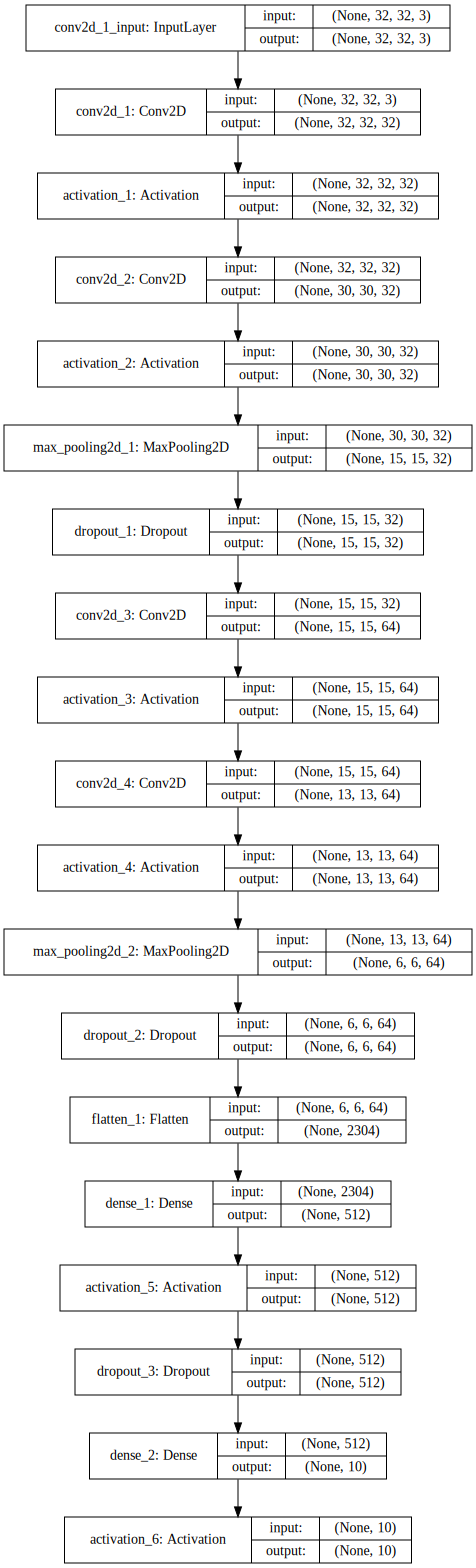

In [7]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model=model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))